# Video style transfer

## Mount Google Drive (please ignore this cell when running on local platforms)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [2]:
%cd /content/drive/Shareddrives/CSCI 590 - Directed Research/Rong/video transfer
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

from tqdm import trange

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models
import torchvision
import HRNet
import utils
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(torch.__version__,device)
print('------------------------------------------------------------------')

/content/drive/Shareddrives/CSCI 590 - Directed Research/Rong/video transfer
------------------------------------------------------------------
1.12.1+cu113 cuda
------------------------------------------------------------------


## Load VGG and HRNet models

In [17]:
torch.manual_seed(0)
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)

style_net = HRNet.HRNet()
#style_net = timm.create_model('hrnet_w18', pretrained=True)

style_net.to(device)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)


In [15]:
for parameter in VGG.parameters():
    print(parameter[0])
    break
for parameter in style_net.parameters():
    print(parameter[0])
    break

tensor([[[-0.0535, -0.0493, -0.0679],
         [ 0.0153,  0.0451,  0.0021],
         [ 0.0362,  0.0200,  0.0199]],

        [[ 0.0170,  0.0554, -0.0062],
         [ 0.1416,  0.2271,  0.1376],
         [ 0.1200,  0.2003,  0.0921]],

        [[-0.0449,  0.0127, -0.0145],
         [ 0.0597,  0.1395,  0.0541],
         [-0.0010,  0.0583, -0.0297]]], device='cuda:0')
tensor([[[ 0.1601]],

        [[ 0.1889]],

        [[-0.3940]]], device='cuda:0', grad_fn=<SelectBackward0>)


## Set hyperparameters

In [18]:

# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.1,
                 'conv2_1': 0.2,
                 'conv3_1': 0.4,
                 'conv4_1': 0.8,
                 'conv5_1': 1.6}

content_weight = 1
style_weight = 1
optimizer = optim.Adam(style_net.parameters(), lr=1e-3)
show_every = 100

## Load content and style images; Convert them into tensors running on the GPU 

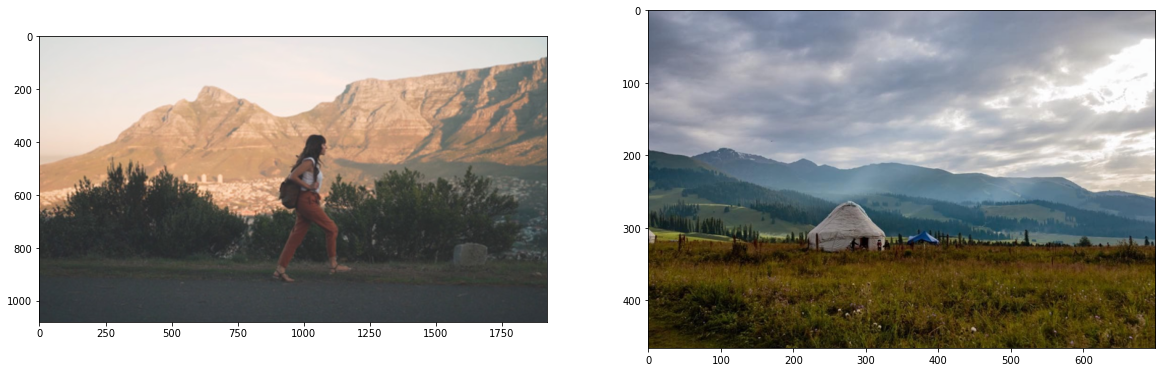

In [19]:

input = utils.load_image("./frame/1.jpg")
content_image = transforms.functional.resize(input, (1080,1920))
content_image = content_image.to(device)
style_image = utils.load_image("./in47.png")
style_image = style_image.to(device)

content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

## Train the HRNet model

After 0 criterions:
Total loss:  3.4377880096435547
Content loss:  3.4377880096435547
Style loss:  2594.61767578125


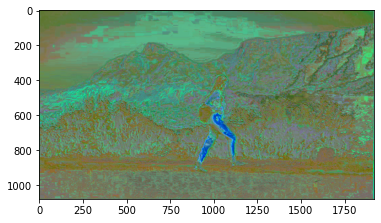

After 100 criterions:
Total loss:  0.21577586233615875
Content loss:  0.21577586233615875
Style loss:  67.31548309326172


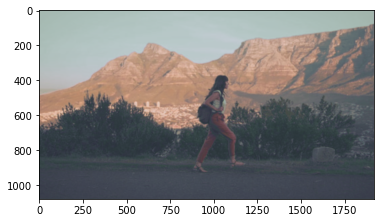

After 200 criterions:
Total loss:  0.0701989009976387
Content loss:  0.0701989009976387
Style loss:  89.5510025024414


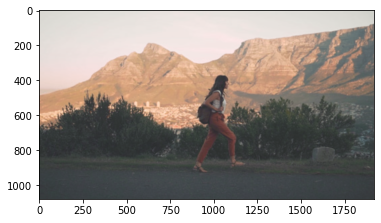

After 300 criterions:
Total loss:  0.03781409561634064
Content loss:  0.03781409561634064
Style loss:  94.60202026367188


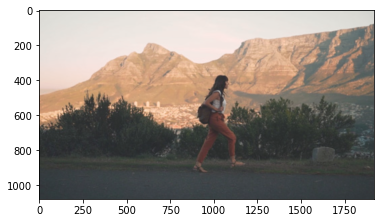

After 400 criterions:
Total loss:  0.026241466403007507
Content loss:  0.026241466403007507
Style loss:  95.61381530761719


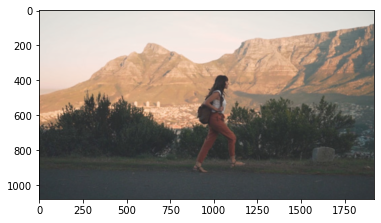

After 500 criterions:
Total loss:  95.77401733398438
Content loss:  0.02182530052959919
Style loss:  95.75218963623047


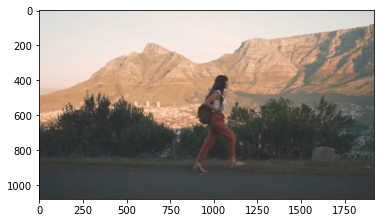

After 600 criterions:
Total loss:  21.99542999267578
Content loss:  0.9527186751365662
Style loss:  21.04271125793457


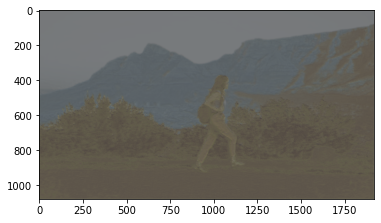

After 700 criterions:
Total loss:  21.393529891967773
Content loss:  0.9364473223686218
Style loss:  20.457082748413086


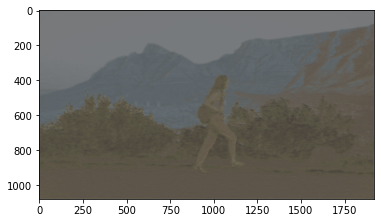

After 800 criterions:
Total loss:  21.1145076751709
Content loss:  0.9515146017074585
Style loss:  20.162992477416992


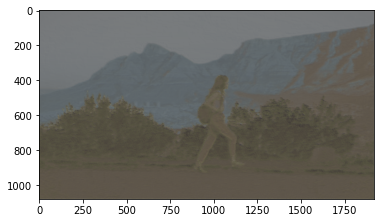

After 900 criterions:
Total loss:  20.826786041259766
Content loss:  0.9333703517913818
Style loss:  19.893415451049805


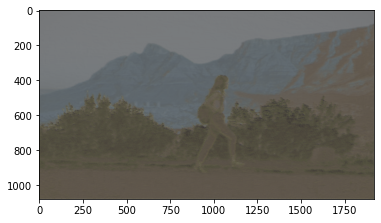

totally cost 569.163991689682


In [20]:
time_start=time.time()
for epoch in range(0, 1000):
    
    if epoch < 500:
        style_weight = 0
    else:
        style_weight = 1
    target = style_net(content_image).to(device)
    target.requires_grad_(True)
    

    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss = style_loss + layer_style_loss / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(utils.im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('totally cost', time_end - time_start)

In [ ]:
# display the raw images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
# content and style ims side-by-side
output_image = transforms.functional.resize(output_image, (input.shape[2],input.shape[3]))

ax1.imshow(utils.im_convert(input))
ax1.set_title('content')
ax2.imshow(utils.im_convert(output_image))
ax2.set_title('transfer')
ax3.imshow(utils.im_convert(style_image))
ax3.set_title('style')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
plt.show()

In [ ]:
for i in trange(1,251):
  input = utils.load_image("./frame/"+str(i)+".jpg")
  content_image = transforms.functional.resize(input, (360,640))
  content_image = content_image.to(device)
  target = style_net(content_image).to(device)
  plt.figure(figsize=(12.8,7.2))
  plt.axis('off')
  plt.imsave('result/'+str(i)+'.jpg',utils.im_convert(target))
